In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ------------------ Configuration ------------------

# Load CSVs
predictions_baseline = pd.read_csv("Results/model_predictions.csv (5-window).csv")
predictions_chronos = pd.read_csv("Results/chronos(5-day).csv")
predictions_timesfm = pd.read_csv("Results/timesfm(5-day).csv")
predictions_uni2ts = pd.read_csv("Results/uni2ts(5-day)predictions.csv")

# Convert 'DlyCalDt' to datetime
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df['DlyCalDt'] = pd.to_datetime(df['DlyCalDt'])

# Sort by date
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df.sort_values(by=["DlyCalDt", "PERMNO"], inplace=True, ignore_index=True)


top_n = 10  # Top N stocks to go long
bottom_n = 10 # Bottom N stocks to go short

# Combine all predictions into a single DataFrame
exclude_columns = ['DlyCalDt', 'PERMNO', 'ExcessReturn']

baseline_cols = predictions_baseline.columns.tolist()
chronos_cols = [cols for cols in predictions_chronos.columns.tolist() if cols not in exclude_columns]
timesfm_cols = [cols for cols in predictions_timesfm.columns.tolist() if cols not in exclude_columns]
uni2ts_cols = [cols for cols in predictions_uni2ts.columns.tolist() if cols not in exclude_columns] 

# Concatenate along axis=1 (columns), aligned by index
combined_df = pd.concat([
    predictions_baseline[baseline_cols],
    predictions_chronos[chronos_cols],
    predictions_timesfm[timesfm_cols],
    predictions_uni2ts[uni2ts_cols]
], axis=1)

combined_df.rename(columns={
    'DlyCalDt': 'Date',
    'ExcessReturn': 'Actual'
}, inplace=True)

In [2]:
combined_df

,PERMNO,Date,Actual,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
0,10138,2016-01-04,-0.018191,0.001656,0.001656,0.000936,0.000671,0.001465,0.000419,0.000662,...,-0.009591,-0.007507,-0.007548,-0.003380,-0.003928,-0.004481,-0.009021,-0.003469,-0.002999,-0.002102
1,17778,2016-01-04,-0.007616,0.001042,0.001042,0.000936,0.000710,0.001242,0.000417,0.000258,...,-0.009653,-0.008324,-0.008974,-0.002516,-0.000681,-0.003673,-0.006993,0.004277,0.000037,0.001335
2,28388,2016-01-04,-0.015413,0.001246,0.001246,0.000956,0.000716,0.001136,0.000421,0.000818,...,-0.016556,-0.013321,-0.004105,-0.006542,-0.006307,-0.003597,-0.009432,-0.002959,0.002250,-0.003005
3,34746,2016-01-04,-0.027370,0.001118,0.001118,0.000842,0.000659,0.001255,0.000406,-0.001097,...,-0.007421,-0.006852,-0.006471,-0.005552,-0.003093,-0.003450,-0.007972,0.003057,0.005902,0.003944
4,35044,2016-01-04,-0.016674,0.001194,0.001194,0.000826,0.000631,0.001268,0.000417,-0.000303,...,-0.004597,-0.005088,-0.005068,-0.005366,-0.002771,-0.002181,-0.007945,0.016010,-0.001052,0.003133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112395,86455,2024-12-31,0.000924,0.000539,0.000539,0.000789,0.000689,0.000884,0.000415,-0.000332,...,-0.013456,-0.010389,-0.006726,-0.009496,-0.004525,-0.003708,-0.009292,0.003837,0.001826,-0.003503
112396,86755,2024-12-31,-0.008607,0.000525,0.000525,0.000778,0.000736,0.000912,0.000415,0.000592,...,-0.017278,-0.014044,-0.011223,-0.013500,-0.007489,-0.006929,-0.009531,-0.003096,-0.001682,0.023733
112397,86868,2024-12-31,-0.001733,-0.000002,-0.000002,0.000432,0.000625,0.000157,0.000414,-0.000107,...,-0.007352,-0.004432,-0.002583,-0.004695,-0.004053,0.000315,-0.005863,0.023588,0.007256,0.008485
112398,87267,2024-12-31,-0.002370,0.001420,0.001420,0.000838,0.000771,0.000939,0.000418,0.000791,...,-0.021085,-0.018935,-0.011643,-0.016488,-0.013070,-0.014655,-0.009866,0.003780,0.000215,0.000637


In [3]:
# Calculate returns for the baseline portfolio

def sharpe_ratio(df, column_name):
    returns = df[column_name]
    cumulative = (1 + returns).cumprod()
    mean_return = returns.mean()
    vol = returns.std()
    sharpe = mean_return / vol * np.sqrt(252)  # Daily Returns, annualized Sharpe Ratio
    return cumulative, sharpe

#print(f"Sharpe Ratio for actual returns: {sharpe:.4f}")

### Sharpe Ratio for actual returns: 0.4552


In [8]:

def build_long_short_portfolio(df, column_name, n=10):
    
    long_short_returns = []
    
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(column_name, ascending=False)
        no_of_stocks = round((n/100)*len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    
    return pd.DataFrame(long_short_returns, columns=["Date", "Returns"])

In [9]:
model_cols = [
    'Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF',
    'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT',
    'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
    'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
    'y_tfm1', 'y_tfm2',
    'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b'
]

portfolio_returns = {}

for model in model_cols:
    ls_df = build_long_short_portfolio(combined_df, model)
    ls_df.set_index('Date', inplace=True)
    portfolio_returns[model] = ls_df['Returns']

# Combine all into one DataFrame
portfolio_df = pd.DataFrame(portfolio_returns)
portfolio_df

,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,NN2,NN3,NN4,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.000854,-0.000854,-0.015783,-0.011359,-0.006818,0.009404,0.006738,-0.010662,0.001010,0.014912,...,0.005205,0.008732,0.011694,0.007367,0.005779,0.008191,0.006025,0.001604,-0.000149,-0.004393
2016-01-05,-0.001575,-0.001575,-0.011879,-0.004539,-0.010181,-0.005757,0.003557,-0.005169,-0.000270,-0.015466,...,0.003094,0.004539,0.003300,-0.003329,0.005000,0.007509,0.010696,-0.005382,0.000236,-0.003270
2016-01-06,-0.005021,-0.005021,-0.012583,-0.012583,-0.007012,-0.007983,0.013492,-0.008722,0.001828,-0.008966,...,0.011364,0.011364,0.007019,0.007021,0.011473,0.012608,0.014847,-0.000620,-0.001368,0.002635
2016-01-07,-0.018233,-0.018233,-0.019752,-0.019752,-0.015286,0.010984,-0.001465,-0.014957,-0.006977,-0.004247,...,0.017642,0.019752,0.012568,0.014096,0.017854,0.012554,0.016275,-0.010857,-0.004298,-0.010089
2016-01-08,-0.003349,-0.003349,-0.002811,0.000025,-0.005441,0.002139,0.011517,0.009074,0.011571,0.008613,...,-0.002842,-0.002607,0.005607,-0.003887,0.005922,0.001886,-0.002812,-0.004395,-0.001168,-0.009449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.007254,0.007254,0.009793,0.010626,0.008176,-0.001309,-0.004145,0.002643,-0.000687,0.001372,...,-0.009616,-0.009665,-0.005490,-0.011683,-0.006191,-0.009853,-0.008178,-0.004300,-0.007131,-0.007587
2024-12-26,0.001937,0.001937,0.000718,0.000449,0.000030,-0.002113,-0.002232,-0.001114,0.005004,0.001001,...,0.000729,-0.000170,0.000661,0.000202,-0.001064,-0.002004,-0.005322,-0.000804,-0.005242,-0.005701
2024-12-27,-0.001980,-0.001980,0.001082,0.000951,-0.002045,0.000221,0.002305,0.003412,-0.001839,0.002821,...,-0.000383,-0.003380,-0.003065,-0.001603,-0.001234,-0.000309,-0.001536,0.000176,-0.000770,-0.000679


In [10]:
# Compute cumulative returns for each model (assuming daily returns)
cumulative_returns = portfolio_df.cumsum()

# Download S&P 500 daily close prices over the same date range
sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())

# Calculate daily returns of S&P 500
sp500['Return'] = sp500['Close'].pct_change()

# Calculate cumulative returns
sp500['Cumulative Return'] = sp500['Return'].cumsum()

# Calculate compounded returns
sp500['Compounded Returns'] = (1+sp500['Return']).cumprod()


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\3246528272.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())
[*********************100%***********************]  1 of 1 completed


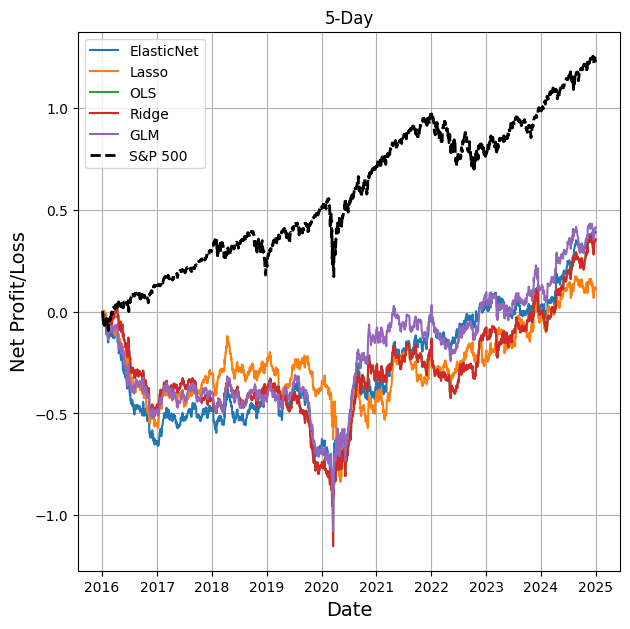

In [12]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

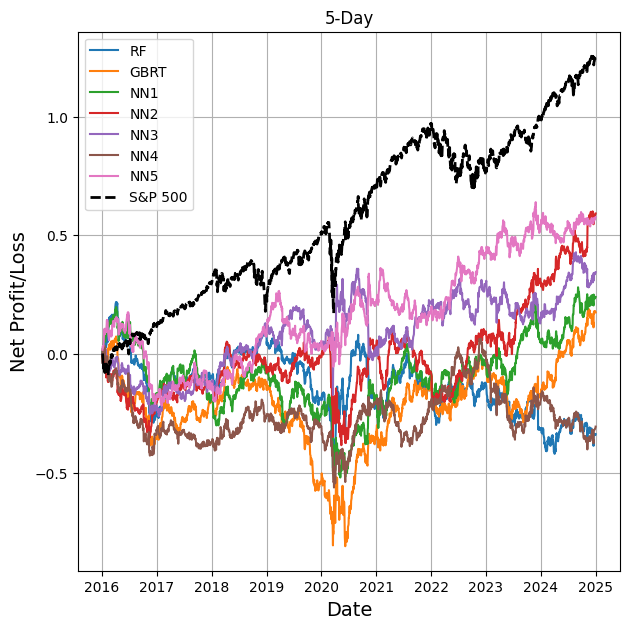

In [ ]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

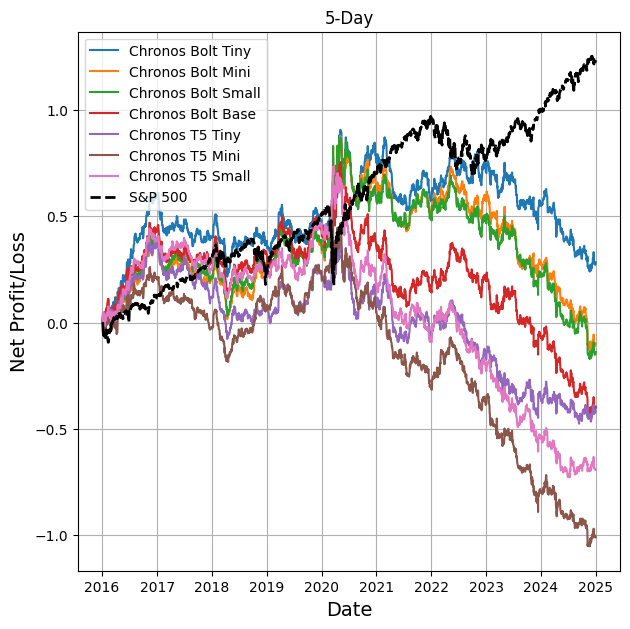

In [14]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


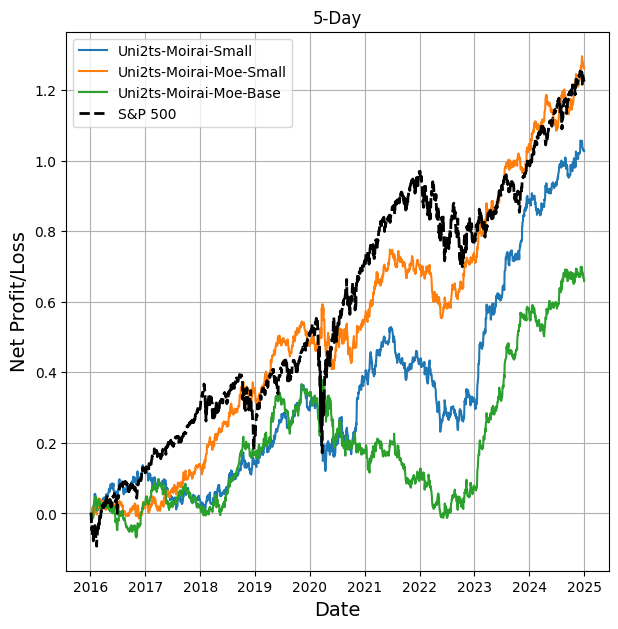

In [15]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Uni2ts-Moirais Models Portfolio Returns")
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


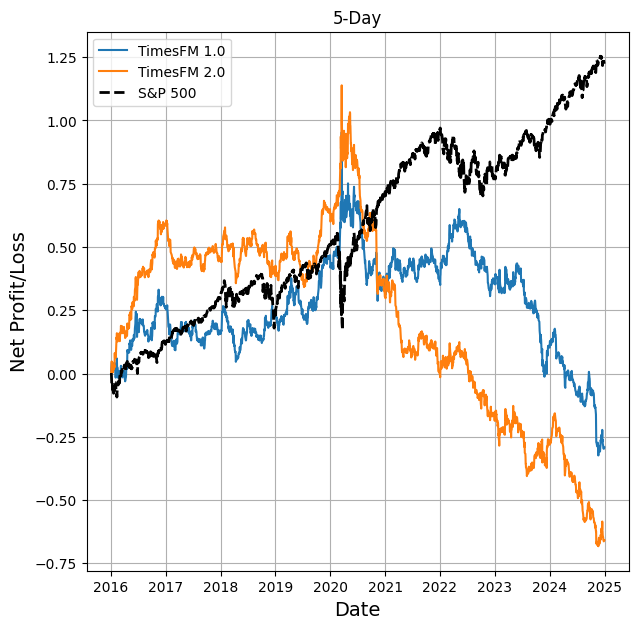

In [16]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(7,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("TimesFM Models Portfolio Returns")
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

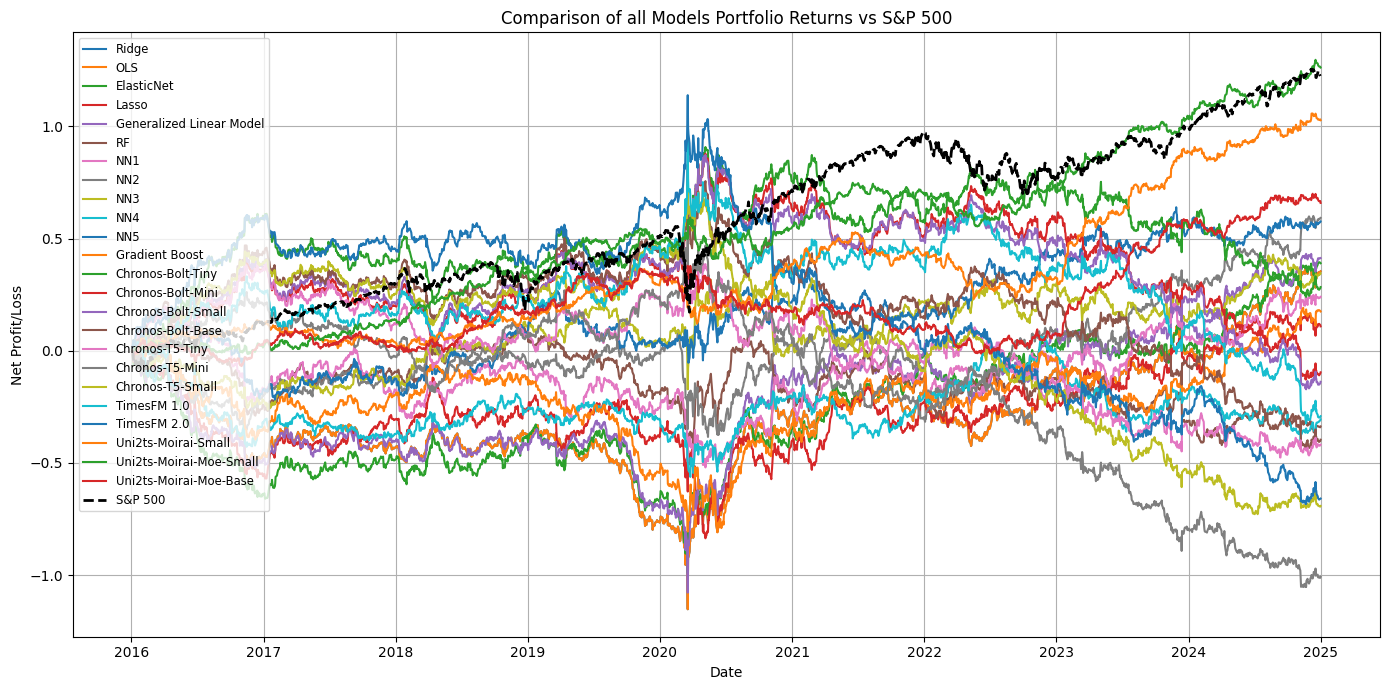

In [ ]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(7,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Portfolio Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
def sharpe_ratio(df, column_name):
    returns = df[column_name]
    cumulative = (1 + returns).cumprod()
    mean_return = returns.mean()
    vol = returns.std()
    sharpe = mean_return / vol * np.sqrt(252)  # Daily Returns, annualized Sharpe Ratio
    return cumulative, sharpe

# Calculate Sharpe ratios for all models
sharpe_ratios = {}
for model in model_cols:
    cumulative, sharpe = sharpe_ratio(portfolio_df, model)
    sharpe_ratios[model] = sharpe

sharpe_ratios_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])

sharpe_ratios_df

,Sharpe Ratio
Ridge,0.165319
OLS,0.165319
ElasticNet,0.184742
Lasso,0.050646
GLM,0.188530
RF,-0.178449
NN1,0.125138
NN2,0.321336
NN3,0.190938
NN4,-0.179869


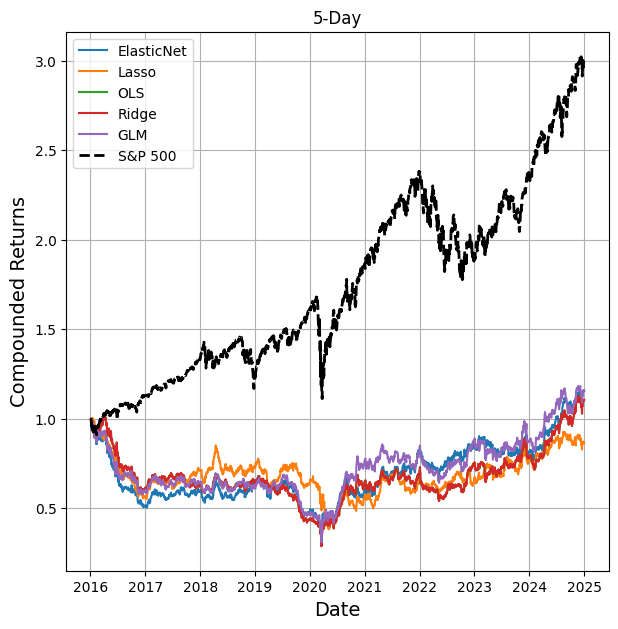

In [18]:
# Plotting compounded returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

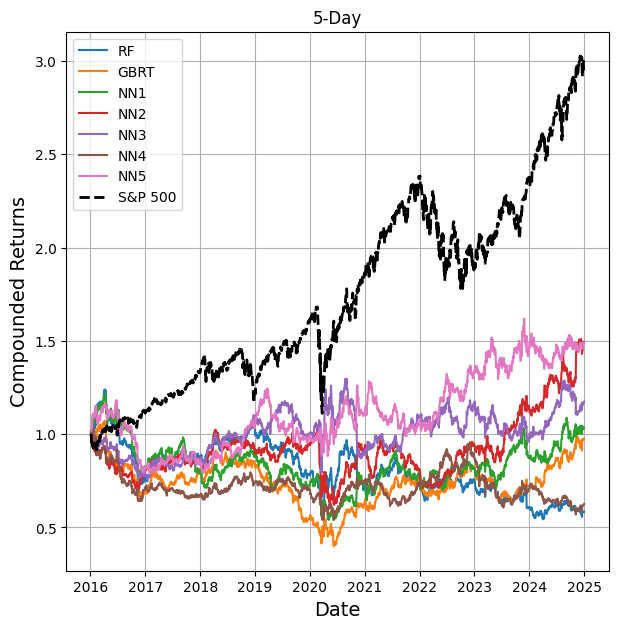

In [19]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

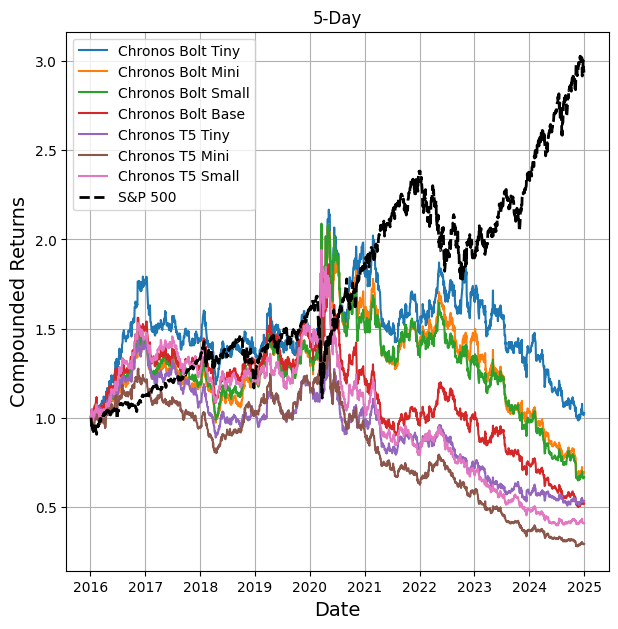

In [20]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


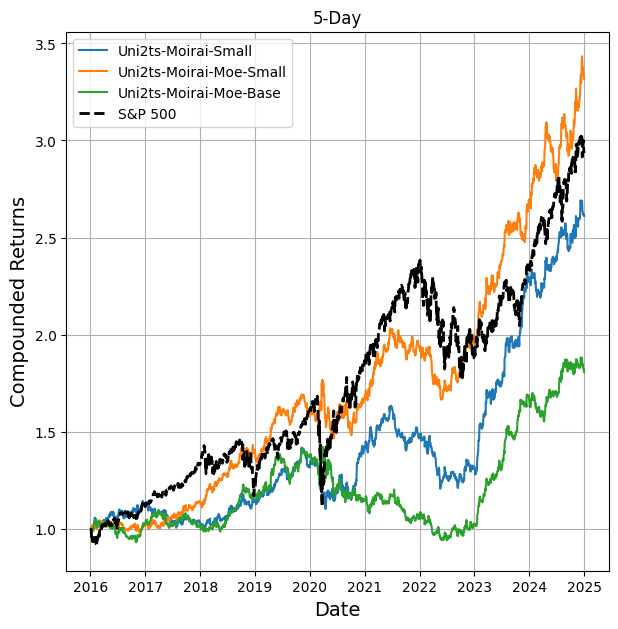

In [21]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


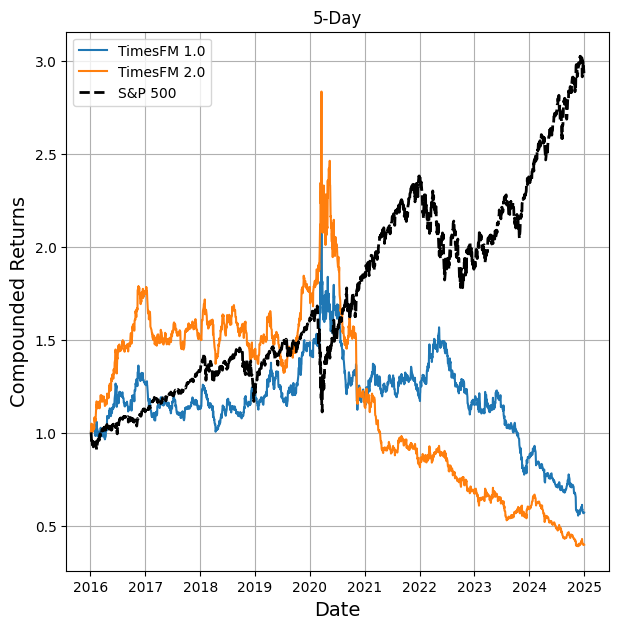

In [22]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(7,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

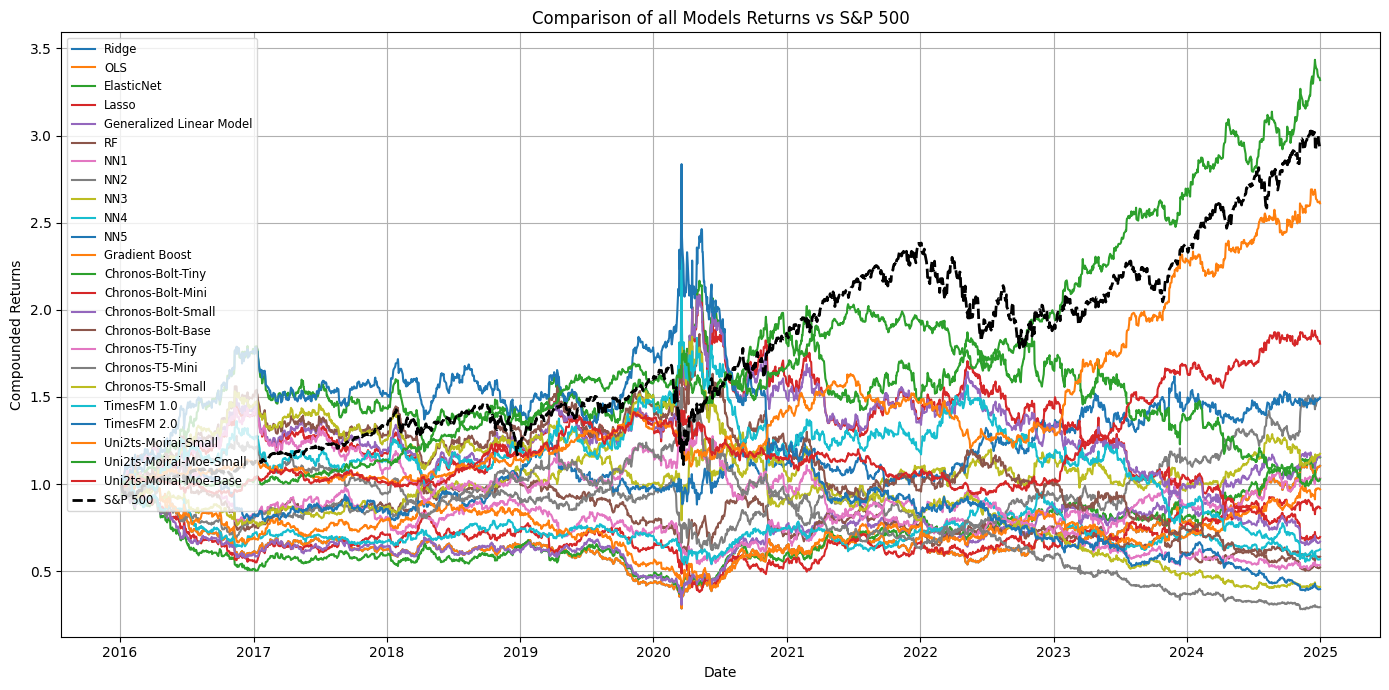

In [ ]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(7,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Function to calculate performance metrics

def performance_metrics(df, column_name):
    returns = df[column_name]

    avg_daily_return = returns.mean()
    ann_return = avg_daily_return * 252
    daily_vol = returns.std()
    ann_vol = daily_vol * np.sqrt(252)
    sharpe = avg_daily_return / daily_vol * np.sqrt(252)

    return {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': ann_return,
        'Daily Volatility': daily_vol,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe    
        }


In [24]:
metrics_dict = {}

for model in model_cols:
    metrics = performance_metrics(portfolio_df, model)
    metrics_dict[model] = {k: v for k, v in metrics.items()}

# Create summary DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

metrics_df

,Avg Daily Return,Annualized Return,Daily Volatility,Annualized Volatility,Sharpe Ratio
Ridge,0.000157,0.039673,0.015117,0.239980,0.165319
OLS,0.000157,0.039673,0.015117,0.239980,0.165319
ElasticNet,0.000174,0.043728,0.014911,0.236697,0.184742
Lasso,0.000048,0.012184,0.015155,0.240572,0.050646
GLM,0.000184,0.046285,0.015465,0.245504,0.188530
RF,-0.000150,-0.037816,0.013349,0.211913,-0.178449
NN1,0.000107,0.026918,0.013550,0.215105,0.125138
NN2,0.000263,0.066326,0.013002,0.206407,0.321336
NN3,0.000153,0.038643,0.012749,0.202388,0.190938
NN4,-0.000136,-0.034280,0.012006,0.190585,-0.179869


In [2]:
import pandas as pd
import numpy as np

def calculate_long_short_returns(df, model_col, n=10):
    long_short_returns = []
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(model_col, ascending=False)
        no_of_stocks = round((n / 100) * len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    return pd.DataFrame(long_short_returns, columns=['Date', 'Returns']).set_index('Date')

def calculate_daily_weights(df, model_col, n=10):
    weights_dict = {}
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(model_col, ascending=False)
        no_of_stocks = round((n / 100) * len(sorted_group))
        weights = pd.Series(0, index=sorted_group['PERMNO'])
        weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks
        weights.loc[sorted_group.tail(no_of_stocks)['PERMNO']] = -1 / no_of_stocks
        weights_dict[date] = weights
    weights_df = pd.DataFrame(weights_dict).T.fillna(0)
    return weights_df

def calculate_daily_turnover(weights_df):
    turnover_list = []
    prev_weights = None
    for date, weights in weights_df.iterrows():
        if prev_weights is None:
            turnover = 0
        else:
            turnover = ((weights - prev_weights).abs().sum()) / 2
        turnover_list.append((date, turnover))
        prev_weights = weights
    turnover_df = pd.DataFrame(turnover_list, columns=['Date', 'Turnover']).set_index('Date')
    return turnover_df

def adjust_returns_with_costs(returns_df, turnover_df, transaction_cost_per_trade=0.0015):
    df = returns_df.copy()
    df = df.join(turnover_df, how='left')
    df['Transaction_Cost'] = transaction_cost_per_trade * df['Turnover']
    df['Returns_Adj'] = df['Returns'] - df['Transaction_Cost']
    return df

def performance_metrics(df, return_col='Returns_Adj'):
    returns = df[return_col].dropna()
    avg_daily_return = returns.mean()
    annualized_return = avg_daily_return * 252
    daily_volatility = returns.std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    metrics = {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': annualized_return,
        'Daily Volatility': daily_volatility,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }
    return metrics

# Your list of model columns
model_cols = ['Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT', 
              'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
              'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
              'y_tfm1', 'y_tfm2',
              'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b']

transaction_cost_per_trade = 0.0002 # 15 bps
n = 10  # top/bottom 10% stocks for long-short

all_metrics = {}
returns_adj_dfs = pd.DataFrame()

for model in model_cols:
    print(f"Processing model: {model}")
    returns_df = calculate_long_short_returns(combined_df, model, n=n)
    weights_df = calculate_daily_weights(combined_df, model, n=n)
    turnover_df = calculate_daily_turnover(weights_df)
    returns_adj_df = adjust_returns_with_costs(returns_df, turnover_df, transaction_cost_per_trade)
    metrics = performance_metrics(returns_adj_df, return_col='Returns_Adj')
    all_metrics[model] = metrics
    returns_adj_dfs[model] = returns_adj_df['Returns_Adj']


# Convert dict of dicts to DataFrame for easier viewing
metrics_df_adj = pd.DataFrame.from_dict(all_metrics, orient='index')
metrics_df_adj = metrics_df_adj.sort_values(by='Sharpe Ratio', ascending=False)

print(metrics_df_adj)


Processing model: Ridge


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: OLS


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: ElasticNet


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: Lasso


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: GLM


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: RF


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN1


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN2


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN3


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN4


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN5


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: GBRT


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_tiny


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_mini


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_small


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_base


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_tiny


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_mini


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_small


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_tfm1


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_tfm2


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_s


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_moe_s


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_moe_b


C:\Users\amaan\AppData\Local\Temp\ipykernel_26780\1500372470.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


                  Avg Daily Return  Annualized Return  Daily Volatility  \
y_moirai_moe_s            0.000208           0.052327          0.007461   
y_moirai_s                0.000101           0.025508          0.007744   
NN2                      -0.000012          -0.002983          0.013002   
NN5                      -0.000027          -0.006837          0.012437   
GLM                      -0.000078          -0.019778          0.015466   
Ridge                    -0.000095          -0.023963          0.015119   
OLS                      -0.000095          -0.023963          0.015119   
NN1                      -0.000090          -0.022653          0.013550   
y_moirai_moe_b           -0.000062          -0.015677          0.007767   
ElasticNet               -0.000151          -0.037952          0.014911   
y_chr_bolt_tiny          -0.000207          -0.052138          0.015028   
NN3                      -0.000176          -0.044306          0.012749   
GBRT                     

In [3]:
metrics_df_adj

,Avg Daily Return,Annualized Return,Daily Volatility,Annualized Volatility,Sharpe Ratio
y_moirai_moe_s,0.000208,0.052327,0.007461,0.118438,0.441813
y_moirai_s,0.000101,0.025508,0.007744,0.122929,0.207498
NN2,-0.000012,-0.002983,0.013002,0.206408,-0.014452
NN5,-0.000027,-0.006837,0.012437,0.197438,-0.034627
GLM,-0.000078,-0.019778,0.015466,0.245520,-0.080555
Ridge,-0.000095,-0.023963,0.015119,0.240003,-0.099847
OLS,-0.000095,-0.023963,0.015119,0.240003,-0.099847
NN1,-0.000090,-0.022653,0.013550,0.215100,-0.105312
y_moirai_moe_b,-0.000062,-0.015677,0.007767,0.123291,-0.127158
ElasticNet,-0.000151,-0.037952,0.014911,0.236707,-0.160335


In [4]:
# Rename columns to corresponding models

returns_adj_dfs

,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,NN2,NN3,NN4,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.000854,-0.000854,-0.015783,-0.011359,-0.006818,0.009404,0.006738,-0.010662,0.001010,0.014912,...,0.005205,0.008732,0.011694,0.007367,0.005779,0.008191,0.006025,0.001604,-0.000149,-0.004393
2016-01-05,-0.001855,-0.001855,-0.012199,-0.004819,-0.010421,-0.005917,0.003397,-0.005369,-0.000590,-0.015786,...,0.002774,0.004259,0.002980,-0.003609,0.004800,0.007229,0.010376,-0.005782,-0.000124,-0.003630
2016-01-06,-0.005301,-0.005301,-0.012863,-0.012903,-0.007252,-0.008223,0.013372,-0.008922,0.001428,-0.009286,...,0.011084,0.011084,0.006699,0.006661,0.011153,0.012368,0.014607,-0.000980,-0.001728,0.002235
2016-01-07,-0.018553,-0.018553,-0.020032,-0.020032,-0.015446,0.010664,-0.001745,-0.015197,-0.007297,-0.004447,...,0.017402,0.019472,0.012288,0.013776,0.017534,0.012394,0.016075,-0.011137,-0.004698,-0.010409
2016-01-08,-0.003589,-0.003589,-0.003131,-0.000295,-0.005721,0.001819,0.011277,0.008834,0.011331,0.008293,...,-0.003122,-0.002887,0.005247,-0.004167,0.005642,0.001646,-0.003052,-0.004755,-0.001488,-0.009809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.006894,0.006894,0.009393,0.010306,0.007776,-0.001589,-0.004305,0.002243,-0.001047,0.001052,...,-0.009976,-0.010025,-0.005770,-0.012043,-0.006551,-0.010253,-0.008498,-0.004660,-0.007451,-0.007907
2024-12-26,0.001777,0.001777,0.000478,0.000049,-0.000210,-0.002433,-0.002592,-0.001474,0.004684,0.000721,...,0.000369,-0.000530,0.000301,-0.000198,-0.001344,-0.002364,-0.005602,-0.001084,-0.005562,-0.006061
2024-12-27,-0.002300,-0.002300,0.000762,0.000631,-0.002365,-0.000139,0.002105,0.003092,-0.002159,0.002501,...,-0.000703,-0.003740,-0.003425,-0.001963,-0.001594,-0.000509,-0.001936,-0.000224,-0.001170,-0.000999


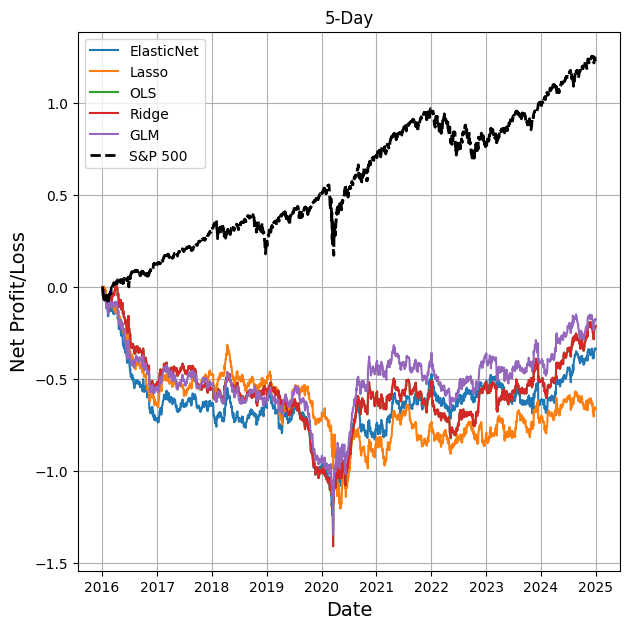

In [11]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

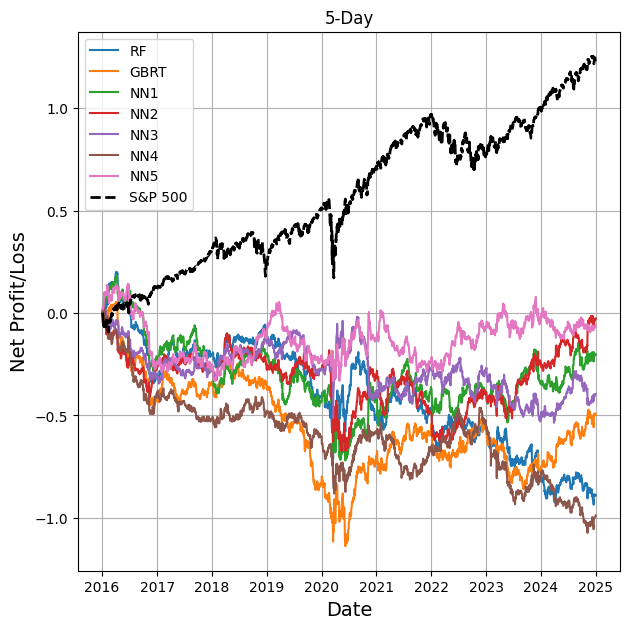

In [12]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

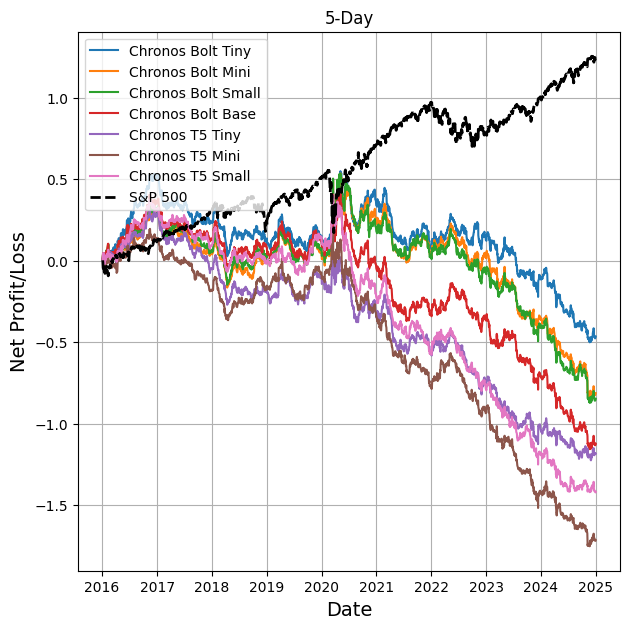

In [13]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

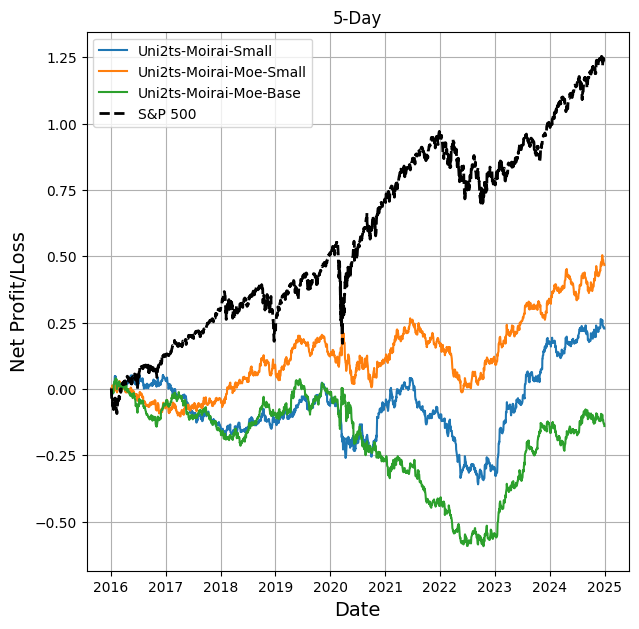

In [14]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Uni2ts-Moirais Models Portfolio Returns")
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


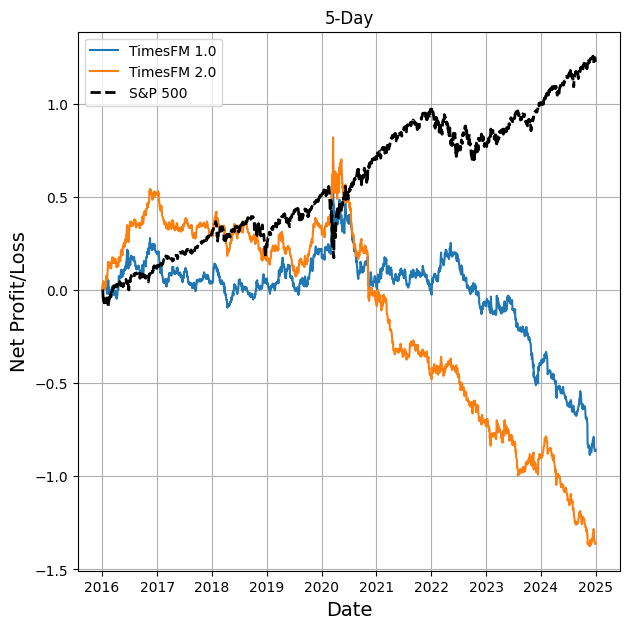

In [ ]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("5-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()